In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

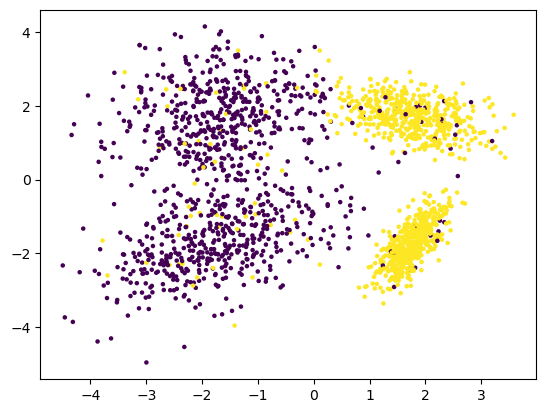

In [2]:
X, y = make_classification(
    n_samples=2000,                  
    n_features=2,                 
    n_redundant=0,                 
    random_state=21,                   
    class_sep=1.75,                    
    flip_y=0.1                    
)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

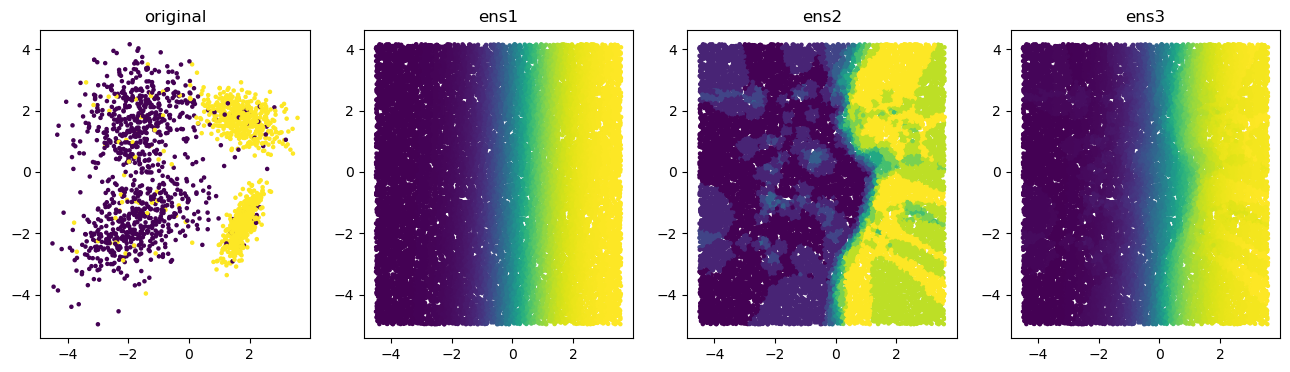

In [3]:
clf1 = LogisticRegression().fit(X,y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X,y)
clf3 = VotingClassifier(
    estimators=[('clf1', clf1), ('clf2', clf2)],
    voting='soft',
    weights=[6,1]
)
clf3.fit(X,y)

X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
plt.figure(figsize=(16,4))
plt.subplot(141)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
plt.title('original')
plt.subplot(142)
plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
plt.title("ens1")
plt.subplot(143)
plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
plt.title("ens2")
plt.subplot(144)
plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
plt.title("ens3");

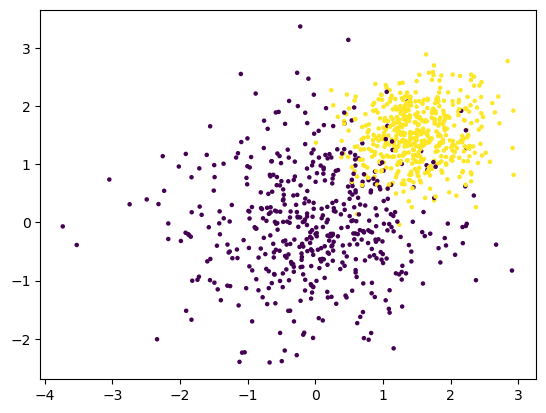

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

from sklego .meta import Thresholder

X,y = make_blobs(1000, centers=[(0,0), (1.5,1.5)], cluster_std=[1,0.5])
plt.scatter(X[:,0], X[:,1], c=y, s=5)

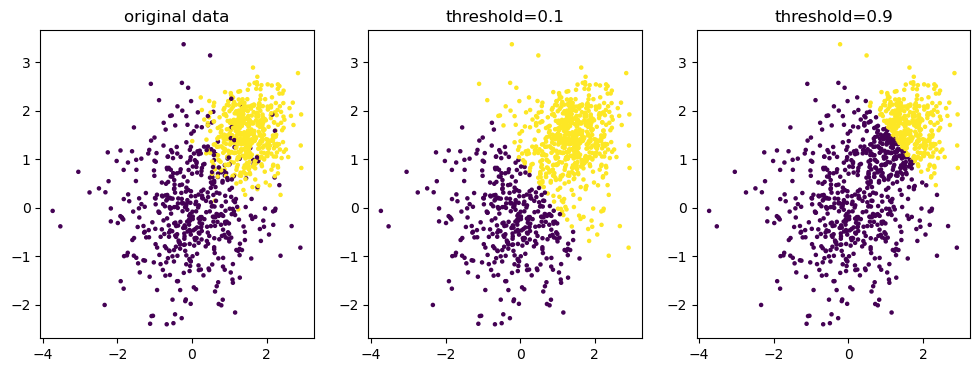

In [6]:
m1 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1).fit(X,y)
m2 = Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.9).fit(X,y)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.title("original data")
plt.subplot(132)
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=5)
plt.title("threshold=0.9");

In [7]:
pipe = Pipeline([
    ('model', Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])
mod = GridSearchCV(
    estimator=pipe,
    param_grid={'model__threshold': np.linspace(0.1, 0.9, 50)},
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score), 
             'accuracy': make_scorer(accuracy_score)},
    refit='precision',
    cv=5
)
mod.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        Thresholder(model=LogisticRegression(),
                                                    threshold=0.1))]),
             param_grid={'model__threshold': array([0.1       , 0.11632653, 0.13265306, 0.14897959, 0.16530612,
       0.18163265, 0.19795918, 0.21428571, 0.23061224, 0.24693878,
       0.26326531, 0.27959184, 0.29591837, 0.3122449 , 0.32857143,
       0.34489796, 0.36122449, 0.37755102, 0.39387755, 0...
       0.58979592, 0.60612245, 0.62244898, 0.63877551, 0.65510204,
       0.67142857, 0.6877551 , 0.70408163, 0.72040816, 0.73673469,
       0.75306122, 0.76938776, 0.78571429, 0.80204082, 0.81836735,
       0.83469388, 0.85102041, 0.86734694, 0.88367347, 0.9       ])},
             refit='precision',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [37]:
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    model.fit(df[['diet', 'time']], df.weight)
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df.weight, metric_df.pred)
    plt.figure(figsize=(12,4))
    for i in [1,2,3,4]:
        pltr = metric_df[['time','diet','pred']].drop_duplicates().loc[lambda d: d.diet == i]
        plt.plot(pltr.time, pltr.pred, color='.rgby'[i])
    plt.title(f'linear model per group, MAE: {np.round(metric, 2)}')
    
df.head()

,weight,time,chick,diet
0,42,0,1,1
1,51,2,1,1
2,59,4,1,1
3,64,6,1,1
4,76,8,1,1


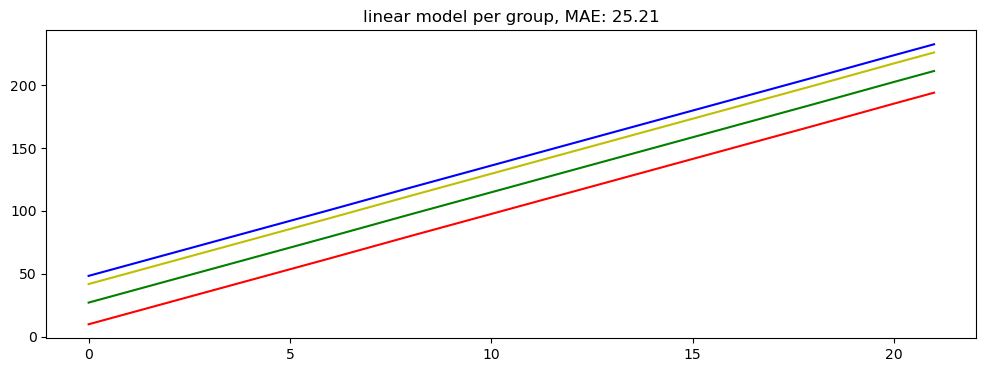

In [41]:
feature_pipeline = Pipeline([ 
    ('datagrab', FeatureUnion([
        ('discrete', Pipeline([
            ('grab', ColumnSelector('diet')),
            ('encode', OneHotEncoder(categories='auto', sparse_output=False))
        ])),
        ('continuous', Pipeline([
            ('grab', ColumnSelector('time')),
            ('standardize', StandardScaler())
        ]))
    ])),
])
pipe = Pipeline([
    ('transform', feature_pipeline),
    ('model', LinearRegression())
])

plot_model(pipe)

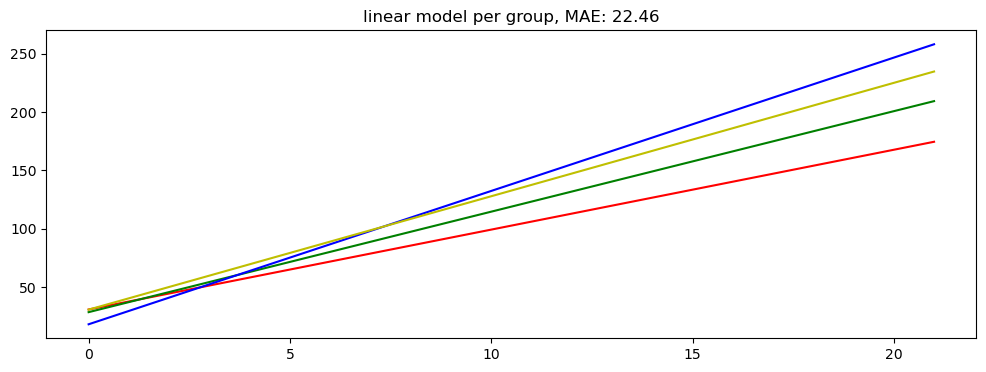

In [42]:
from sklego.meta import GroupedPredictor
mod = GroupedPredictor(LinearRegression(), groups=['diet'])
plot_model(mod)

,index,yt,date,m
0,0,0.468623,2000-01-01,1
1,1,-0.653622,2000-01-02,1
2,2,-0.615641,2000-01-03,1
3,3,-0.891481,2000-01-04,1
4,4,0.074618,2000-01-05,1
...,...,...,...,...
1820,1820,0.650863,2004-12-25,12
1821,1821,0.859795,2004-12-26,12
1822,1822,0.470901,2004-12-27,12
1823,1823,1.399010,2004-12-28,12


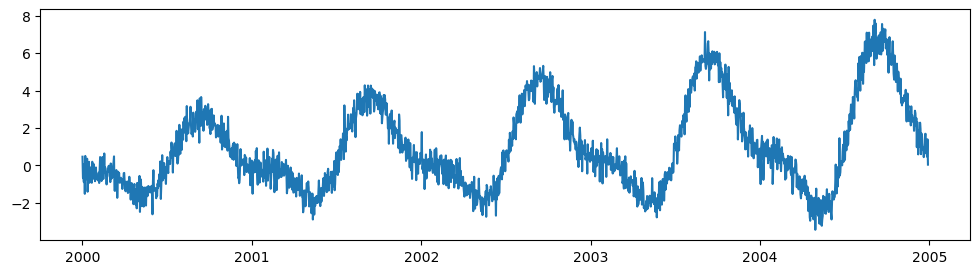

In [66]:
from sklego.meta import DecayEstimator
from sklego.datasets import make_simpleseries
from sklearn.dummy import DummyRegressor

yt = make_simpleseries(seed=1)
dates = pd.date_range('2000-01-01', periods=len(yt))
df = (pd.DataFrame({'yt': yt,
                   'date': dates})
      .assign(m=lambda d: d.date.dt.month)
     .reset_index())

plt.figure(figsize=(12,3))
plt.plot(dates, make_simpleseries(seed=1))

df

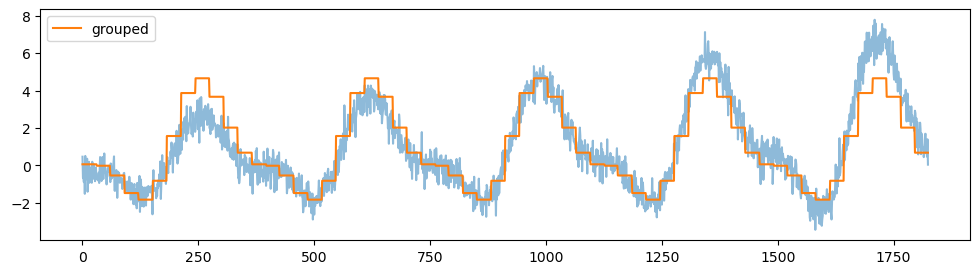

In [67]:
mod = (GroupedPredictor(DummyRegressor(), groups=['m']))
mod.fit(df[['m']], df[['yt']])

plt.figure(figsize=(12,3))
plt.plot(df.yt, alpha=0.5)
plt.plot(mod.predict(df[['m']]), label='grouped')
plt.legend()

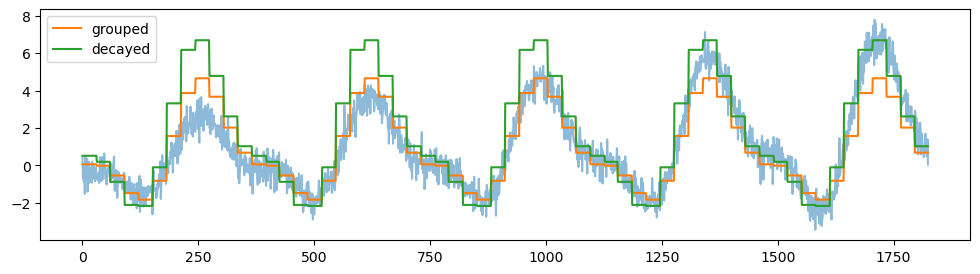

In [74]:
mod2 = (GroupedPredictor(DecayEstimator(DummyRegressor(), decay=0.9), groups=['m']))
mod2.fit(df[['index', 'm']], df.yt)

plt.figure(figsize=(12,3))
plt.plot(df.yt, alpha=0.5)
plt.plot(mod.predict(df[['m']]), label='grouped')
plt.plot(mod2.predict(df[['index','m']]), label='decayed')
plt.legend()